## Bank Marketing Prediction 

## Objectives

The goal is to predict if the client, who received marketing phone calls, will subscribe to a bank service (term deposit). 

Besides developing a classification model to predict if a client will subscribe to the service, I want to analyze how effective was the campaign and what type of client was more likely to subscribe.

I am using the [Bank Marketing Dataset](http://archive.ics.uci.edu/ml/datasets/Bank+Marketing#) from the UCI Machine Learning Repository

In [1]:
#Imports

# Data munging and exploration
import numpy as np
from numpy import mean
from numpy import std
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline 
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

# Data pre-processing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler

#Feature Selection
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif, RFE,RFECV, chi2
from sklearn.pipeline import Pipeline

#Modeling
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

#Metrics
from sklearn.metrics import accuracy_score,precision_score,confusion_matrix, classification_report

#Hiding warnings
import warnings
warnings.filterwarnings("ignore")

## Loading data

In [2]:
#Loading train dataset
bank=pd.read_csv('data/bank-full.csv',  sep=';')

In [3]:
# Checking the dataset

print("\n Bank dataset dimensions", bank.shape)
print("\n Columns info", bank.info())


 Bank dataset dimensions (45211, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB

 Columns info None


## Data Exploration and Feature Engineering

<strong> y: target variable - </strong> Has the client subscribed to a term deposit? yes/no

In [4]:
#Checking how many customers have subscribed to the service
bank.groupby('y').size()

y
no     39922
yes     5289
dtype: int64

There are two things that I'll have to work on here. First, I'll have to recode 'yes' and 'no' to numbers because the algorithms won't read the way it is now. Also, the categories are pretty unbalanced. I'll have to balance the dataset before modeling.

In [5]:
#Taking a look at the proportion of the categories
no_sub= len(bank[bank['y']=='no'])
do_sub= len(bank[bank['y']=='yes'])
pc_sub= do_sub/(do_sub + no_sub)
print("share of clients subscribing to the service:", round(pc_sub*100, 2))
pc_no_sub= no_sub/(do_sub + no_sub)
print("share of clients not subscribing to the service:", round(pc_no_sub*100, 2))

share of clients subscribing to the service: 11.7
share of clients not subscribing to the service: 88.3


In [6]:
#Changing labels

#creating a dictionary to change labels:
y_labels={"y":{"yes":1,"no":0}}

#changing the columns in the dataset and taking a look
bank.replace(y_labels, inplace=True)

<strong> Client data </strong>

<strong> Age </strong>

In [7]:
##Defining function to create histograms
def hist_graph(data,column):
    sns.histplot(data=data, x=column, color='teal')

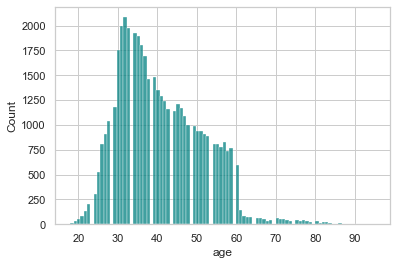

In [8]:
#checking the distribution of the variable
hist_graph(bank,'age')

Most clients are between 30-40 and 40-50 years of age. How about those who subscribed to the service?

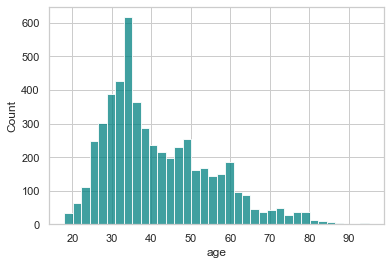

In [9]:
#distribution when y=1
bank_y=bank[bank['y']==1]
hist_graph(bank_y,'age')

They are mostly on their late 20s and between 30-40 years of age

<strong> Balance </strong>

In [10]:
bank['balance'].describe()

count     45211.000000
mean       1362.272058
std        3044.765829
min       -8019.000000
25%          72.000000
50%         448.000000
75%        1428.000000
max      102127.000000
Name: balance, dtype: float64

In [11]:
bank_y['balance'].describe()

count     5289.000000
mean      1804.267915
std       3501.104777
min      -3058.000000
25%        210.000000
50%        733.000000
75%       2159.000000
max      81204.000000
Name: balance, dtype: float64

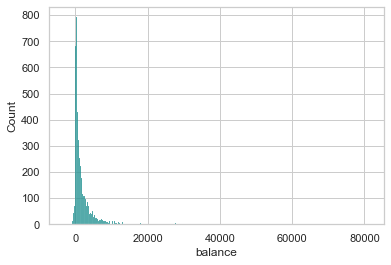

In [12]:
hist_graph(bank_y,'balance')

Clients who subscribed to the service have in average a balance slightly higher than those who don't. Distribution is skewed to the left.

<strong> Job </strong>

In [13]:
#Defining function to create count graphs
def count_graph(data,column):
    sns.catplot(y=column, data=data, kind="count", color='darkturquoise',
           order = data[column].value_counts().index)

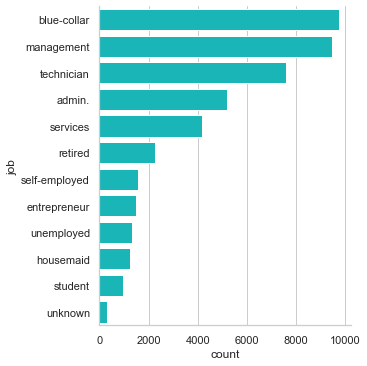

In [14]:
#Count
count_graph(bank,'job')

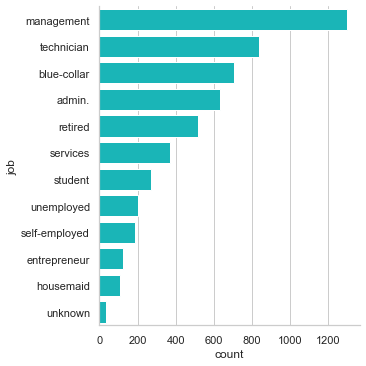

In [15]:
# Count of clients who got the service
count_graph(bank_y,'job')

Despite having more blue-collar workers in the dataset, managers and technicians are the ones who subscribed more to the service.

<strong> Marital </strong>

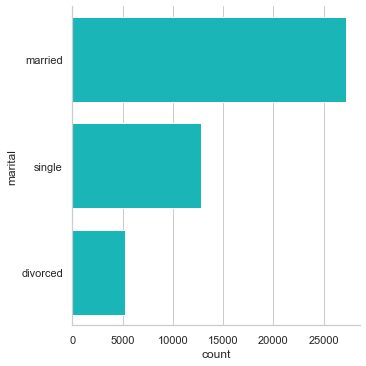

In [16]:
count_graph(bank,'marital')

<strong> Education </strong>

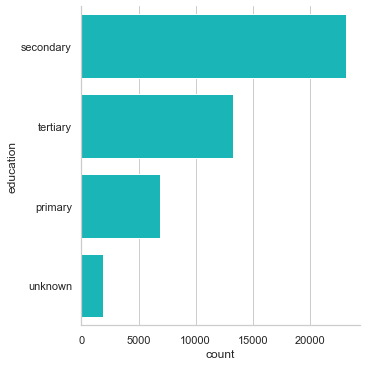

In [17]:
count_graph(bank,'education')

Most clients in the dataset are married and has secondary education 

<strong> Default: </strong> has credit in default?

In [18]:
#Defining function to automate group_by and count values
def group_count(data,column):
    print(data.groupby(column).size())

In [19]:
group_count(bank,'default')

default
no     44396
yes      815
dtype: int64


In [20]:
#did clients who got the service have credit in default?
group_count(bank_y,'default')

default
no     5237
yes      52
dtype: int64


<strong> Housing </strong>

In [21]:
group_count(bank,'housing')

housing
no     20081
yes    25130
dtype: int64


In [22]:
#Checking the proportions
print('\n no housing:',round(20081*100/len(bank),3))
print('\n housing:', round(25130*100/len(bank),3))


 no housing: 44.416

 housing: 55.584


In [23]:
#did clients who got the service have a house?
group_count(bank_y,'housing')

housing
no     3354
yes    1935
dtype: int64


In [24]:
#Checking the proportions
print('\n no housing:',round(3354*100/len(bank_y),3))
print('\n housing:', round(1935*100/len(bank_y),3))


 no housing: 63.415

 housing: 36.585


Most clients who subscribed to the service do not have a house, differently from the overall pattern found in the whole dataset. 

<strong> Loan </strong>

In [25]:
group_count(bank,'loan')

loan
no     37967
yes     7244
dtype: int64


In [26]:
#Checking the proportions
print('\n no loan:',round(37967*100/len(bank),3))
print('\n loan:', round(7244*100/len(bank),3))


 no loan: 83.977

 loan: 16.023


In [27]:
#did clients who got the service have a loan?
group_count(bank_y,'loan')

loan
no     4805
yes     484
dtype: int64


In [28]:
#Checking the proportions
print('\n no loan:',round(4805*100/len(bank_y),3))
print('\n loan:', round(484*100/len(bank_y),3))


 no loan: 90.849

 loan: 9.151


<strong> Data about the last contact of the current campaign </strong>

<strong> contact: </strong> contact communication type (categorical: 'cellular','telephone') 

In [29]:
group_count(bank,'contact')

contact
cellular     29285
telephone     2906
unknown      13020
dtype: int64


<strong> day: </strong> day of the month

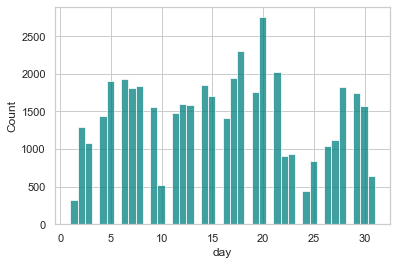

In [30]:
hist_graph(bank,'day')

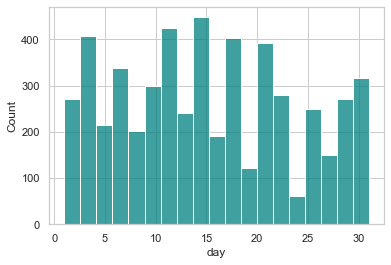

In [31]:
hist_graph(bank_y,'day')

<strong> month </strong>

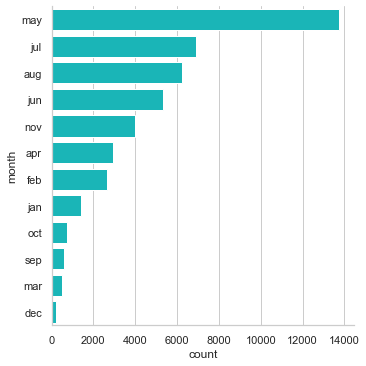

In [32]:
count_graph(bank,'month')

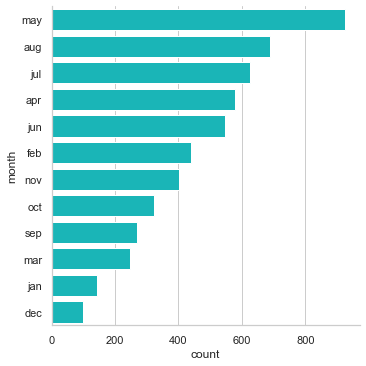

In [33]:
count_graph(bank_y,'month')

<strong> duration: </strong> past contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

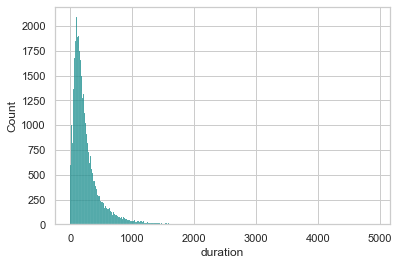

In [34]:
hist_graph(bank,'duration')

Since I wanna develop a predictive model I won't be able to use this feature since it is not possible to know how long the call will be before hand, which will be impossible to make a prediction about new calls. In this sense, I'll drop this feature.

In [35]:
del bank['duration']

<strong> Data related to the campaign </strong>

<strong> Campaign: </strong> number of contacts performed during the campaign for this client

In [36]:
bank['campaign'].describe()

count    45211.000000
mean         2.763841
std          3.098021
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         63.000000
Name: campaign, dtype: float64

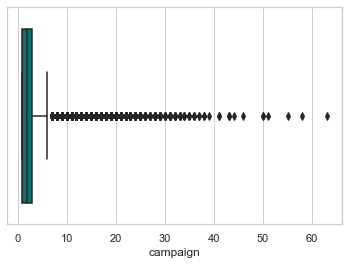

In [37]:
#Distribution of the campaign variable
sns.boxplot(x=bank['campaign'], color='teal')

count    5289.000000
mean        2.141047
std         1.921826
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        32.000000
Name: campaign, dtype: float64


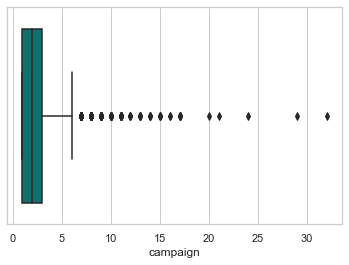

In [38]:
#Distribution of the campaign variable only for clients who got the 
#service
print(bank_y['campaign'].describe())
sns.boxplot(x=bank_y['campaign'], color='teal')

In [39]:
print('Length of the dataset:', len(bank))
print('How many clients got more than 5 calls:',len(bank[bank['campaign']>5]))
print('Proportion of clients who got more than 5 calls:',round(len(bank[bank['campaign']>5])/len(bank)*100),'%')

Length of the dataset: 45211
How many clients got more than 5 calls: 4355
Proportion of clients who got more than 5 calls: 10 %


Each client got around 2 to 3 calls on average on the whole dataset and among those who got the service. However, around 10% of the clients got more than 5 calls. It is a lot of calls and it may bother the clients to get so many of them. Let's see how many clients who got more than 5 calls subscribed to the service:

In [40]:
print("Proportion of clients who subscribed to the service and got more than 5 calls:",
round(len(bank_y[bank_y['campaign']>5])/len(bank_y)*100),'%')

print('Absolute number of clients who subscribed and received 5 calls:',len(bank_y[bank_y['campaign']>5]))

Proportion of clients who subscribed to the service and got more than 5 calls: 5 %
Absolute number of clients who subscribed and received 5 calls: 253


Only 5% of the clients who subscribed to the service received more than 5 calls. Only 253 clients that received more than five calls got the service in a total of 45211 clients. This is less than 1% of the dataset. It seems like a loss of time and resources just to get a few more clients that could be used in another strategy (like getting more clients and offer them this service, for example)

<strong> pdays: </strong> number of days that passed by after the client was last contacted from a previous campaign 

In [41]:
print('Head',bank.groupby('pdays').size().head())
print('Tail',bank.groupby('pdays').size().tail())

Head pdays
-1    36954
 1       15
 2       37
 3        1
 4        2
dtype: int64
Tail pdays
838    1
842    1
850    1
854    1
871    1
dtype: int64


Most of the cases has -1 as value. The data dictionary does not have any information about this value. It just says that if a client was not contacted it received the value 999, but there is no case with this value.

In [42]:
print('Proportion of clients that were assigned -1 in pdays',round(36954/45211*100,2),'%')

Proportion of clients that were assigned -1 in pdays 81.74 %


<strong> previous: </strong> number of contacts performed before this campaign and for this client (numeric)

In [43]:
group_count(bank,'previous')

previous
0      36954
1       2772
2       2106
3       1142
4        714
5        459
6        277
7        205
8        129
9         92
10        67
11        65
12        44
13        38
14        19
15        20
16        13
17        15
18         6
19        11
20         8
21         4
22         6
23         8
24         5
25         4
26         2
27         5
28         2
29         4
30         3
32         1
35         1
37         2
38         2
40         1
41         1
51         1
55         1
58         1
275        1
dtype: int64


The number of zeros are the same of -1 in the pdays feature. This means that -1 in pdays is the same as zero days that passed after the client was contacted. I say it is zero days because actually the clients were never contacted. I can create another variable based on these two that will tell me if the client was ever contacted before. Before that I should check the outcome varible to see if it gives me this information (if there was a campaign call with the client or not)

<strong> poutcome: </strong> outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

In [44]:
group_count(bank,'poutcome')

poutcome
failure     4901
other       1840
success     1511
unknown    36959
dtype: int64


It seems that this more than 36.000 cases are clients that were not targeted on previous campaigns. I'll take a closer look on these cases.

In [45]:
#Creating a dataset with only pdays== -1
df_pdays=bank[bank['pdays']==-1]
print(len(df_pdays))

36954


In [46]:
group_count(df_pdays,'previous')

previous
0    36954
dtype: int64


In [47]:
df_pdays['campaign'].describe()

count    36954.000000
mean         2.921957
std          3.325791
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         63.000000
Name: campaign, dtype: float64

Like I've imagined, pdays and previous presents values -1 and 0 for clients that were not contacted on previous campaigns and this was a huge amount (81%) of all clients. However they were contacted on this new campaign.

In [48]:
#Checking the correlation between pdays and previous
prev=['pdays','previous']
corr = bank[prev].corr()
corr

,pdays,previous
pdays,1.00000,0.45482
previous,0.45482,1.00000


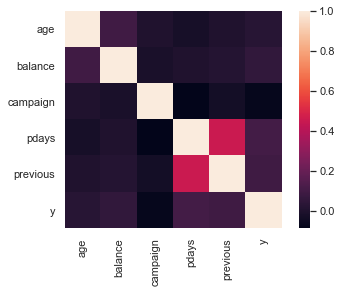

In [49]:
#Correlation of numerical  features

sns.heatmap(bank[['age','balance', 'campaign',
                       'pdays','previous','y']].corr(),vmax=1., square=True)

In [50]:
#Replacing -1 to zero on pdays
bank['pdays']=bank['pdays'].replace(-1,0)

There's some correlation but I don't think it is too high. I'll keep both features

In [51]:
#Transforming categorical variables

#I'll separate lists with numerical and categorical features to
#simplify data manipulation

num=['age','balance', 'campaign','pdays','previous']

cat=[i for i in bank.columns if i not in num]

print('\nNumerical Features:', num)
print('\nCategorial Features:', cat)


Numerical Features: ['age', 'balance', 'campaign', 'pdays', 'previous']

Categorial Features: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'day', 'month', 'poutcome', 'y']


In [52]:
#Education is an ordinal category. I'll encode it separately from the 
#others, so I'll have to take it off my cat list. I'll also take off 
#the target variable

cat.remove('education')
cat.remove('y')
print(cat)


['job', 'marital', 'default', 'housing', 'loan', 'contact', 'day', 'month', 'poutcome']


In [53]:
#I'll do one hot encoding for all features in cat

#one hot encoding using pandas
bank=pd.get_dummies(bank, columns=cat)


In [54]:
#Ordinal Encoding for education

#defining dictionary
education_dic={'education':{'unknown':0,'primary':1,'secondary':2,
                            'tertiary':3}}

#replacing
bank=bank.replace(education_dic)

In [55]:
#Transforming categorical variables (again)

#I'll separate lists with numerical and categorical features to
#simplify data manipulation

num=['age','balance', 'campaign','pdays','previous']

cat=[i for i in bank.columns if i not in num]

print('\nNumerical Features:', num)
print('\nCategorial Features:', cat)


Numerical Features: ['age', 'balance', 'campaign', 'pdays', 'previous']

Categorial Features: ['education', 'y', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married', 'marital_single', 'default_no', 'default_yes', 'housing_no', 'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular', 'contact_telephone', 'contact_unknown', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'day_7', 'day_8', 'day_9', 'day_10', 'day_11', 'day_12', 'day_13', 'day_14', 'day_15', 'day_16', 'day_17', 'day_18', 'day_19', 'day_20', 'day_21', 'day_22', 'day_23', 'day_24', 'day_25', 'day_26', 'day_27', 'day_28', 'day_29', 'day_30', 'day_31', 'month_apr', 'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'poutcome_failure', 'pout

## Splitting, Balancing and Scaling Data

Splitting data. I'll stratify by the target variable to ensure I have the same proportion of both classes in training and testing. Then I'll re-index both datasets to avoid NAN when scaling data.


**Splitting data**

In [56]:
## Separating X and y
X=bank.loc[:, bank.columns != 'y']
y=bank['y']

In [57]:
#Splitting

X_train, X_test, y_train, y_test= train_test_split(
    X,y, test_size=0.2, random_state=42, stratify=bank['y'], shuffle=True)

In [58]:
#Re-index to avoid NAN when scaling data
X_train=X_train.reset_index(drop=True)
X_test=X_test.reset_index(drop=True)

<strong> Balancing the training dataset </strong>

In [59]:
#Defining SMOTE object. I'll increase minority class to have 70% the
#number of examples of the majority class

#Creating objects
over = SMOTE(sampling_strategy=0.7, random_state=42)

#Resampling
X_train, y_train = over.fit_resample(X_train, y_train)

In [60]:
y_train.value_counts()

0    31937
1    22355
Name: y, dtype: int64

<strong> Scaling data </strong>

In [61]:
#Scaling numeric features. I'll use MinMaxScaler so the variables will
# be between 0 and 1
scaler = MinMaxScaler() 

X_train[num]= pd.DataFrame(scaler.fit_transform(X_train[num]))
X_test[num]= pd.DataFrame(scaler.fit_transform(X_test[num]))

In [62]:
#Education is an ordinal category. I'll encode it separately from the 
#others, so I'll have to take it off my cat list. I'll also take off 
#the target variable

cat.remove('education')
cat.remove('y')
print(cat)


['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married', 'marital_single', 'default_no', 'default_yes', 'housing_no', 'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular', 'contact_telephone', 'contact_unknown', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'day_7', 'day_8', 'day_9', 'day_10', 'day_11', 'day_12', 'day_13', 'day_14', 'day_15', 'day_16', 'day_17', 'day_18', 'day_19', 'day_20', 'day_21', 'day_22', 'day_23', 'day_24', 'day_25', 'day_26', 'day_27', 'day_28', 'day_29', 'day_30', 'day_31', 'month_apr', 'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'poutcome_failure', 'poutcome_other', 'poutcome_success', 'poutcome_unknown']


In [63]:
#Transforming objects to category using cat list
for column in X_train[cat]:
    X_train[column]=X_train[column].astype('category')

In [64]:
for column in X_test[cat]:
    X_test[column]=X_test[column].astype('category')
    

In [65]:
#transforming y into category
y_train=y_train.astype('category')
y_test=y_test.astype('category')

In [66]:
#exporting datasets
X_train.to_csv('data/X_train.csv')
y_train.to_csv('data/y_train.csv')
X_test.to_csv('data/X_test.csv')
y_test.to_csv('data/y_test.csv')

## Feature Selection

I'll do the feature selection using the train dataset. I'll run some feature selection techniques to verify how many features I'll add to the model based on their importance. Then I'll run some models through cross-validation to decide which set of features delivers better accuracy scores.

**Checking number of features**

Before running the feature selection techniques I'll check how many features I should use by running a Recursive Feature Elimination with Cross-Validation (RFECV) and verifying the accuracy scores of decision trees with different numbers of features.

In [67]:
# Create the RFE object and compute a cross-validated score.

#Estimator will be a decision tree
est = DecisionTreeClassifier(random_state=0)

# Minimum number of features to consider
min_features_to_select = 1  

#RFECV
rfecv = RFECV(est, step=1, cv=KFold(n_splits=5),
              scoring='accuracy',
              min_features_to_select=min_features_to_select)
rfecv.fit(X_train, y_train)


print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 70


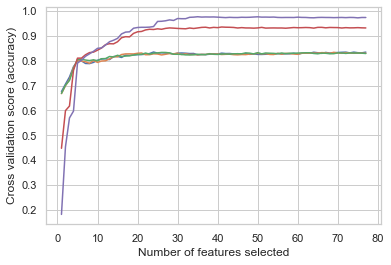

In [68]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel('Number of features selected')
plt.ylabel('Cross validation score (accuracy)')
plt.plot(range(min_features_to_select,
               len(rfecv.grid_scores_) + min_features_to_select),
         rfecv.grid_scores_)
plt.show()

In [69]:
# get a list of models to evaluate
def get_models():
    models = dict()
    for i in range(10, 35,5):
        rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=i)
        model = DecisionTreeClassifier()
        models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
    return models
 
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = KFold(n_splits=5)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

In [70]:
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    print('>%s features %.3f (%.3f)' % (name, mean(scores), std(scores)))

>10 features 0.818 (0.024)
>15 features 0.844 (0.033)
>20 features 0.866 (0.049)
>25 features 0.874 (0.056)
>30 features 0.875 (0.060)


The RFECV indicates that the best number of features would be 70. However, since I just checked accuracy it is likely that a model with 70 features and really high scores would be overfitting. The graph shows an important jump in accuracy score values from 10 to 30 features and then the values stabilize, not showing great improvement as features are added. I'll do the feature selection with 20 features and will evaluate the results to consider reducing this number even more.  

**SelectKBest**

In [71]:
#Creating object SelectKBest

skb=SelectKBest(chi2, k=20)

#Applying to data
best_skb = skb.fit_transform(X_train, y_train)

# Saving the best predictors in a list
feat_skb=X_train.columns[skb.get_support()]

In [72]:
#Creating series with scores
skb_series=pd.Series(skb.scores_, index=X_train.columns)

#Sorting ascending
skb_series=skb_series[feat_skb].sort_values(ascending=True)


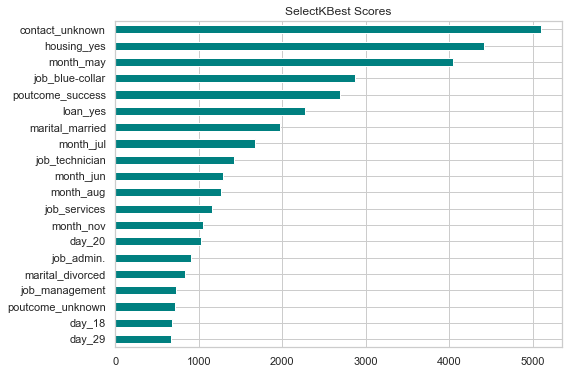

In [73]:
#Plotting scores
skb_series.plot(kind='barh', color='teal', figsize=(8,6),
               title='SelectKBest Scores')

**Information Gain**

In [74]:
#Creating object
ig=mutual_info_classif(X_train, y_train)

#Saving scores in a pandas series.
ig_series = pd.Series(ig, index = X_train.columns)

#Saving in decreasing order.
ig_series = ig_series.sort_values(ascending = False).head(20)

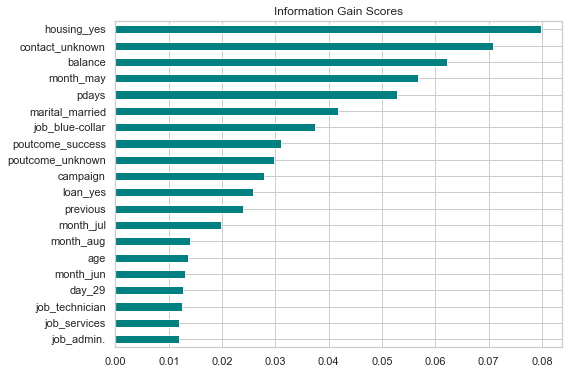

In [75]:
#Plotting scores
ig_series.sort_values(ascending=True).plot(kind='barh', color='teal', 
                                           figsize=(8,6), title='Information Gain Scores')

**Extra Trees Feature Importance**

In [76]:
#Creating object (default hyperparameters)

etc=ExtraTreesClassifier()

#Fitting algorithm
etc.fit(X=X_train, y=y_train)

#Adding scores to a series
etc_series=pd.Series(etc.feature_importances_, index=X_train.columns)

#Sorting
etc_series=etc_series.sort_values(ascending=False).head(20)

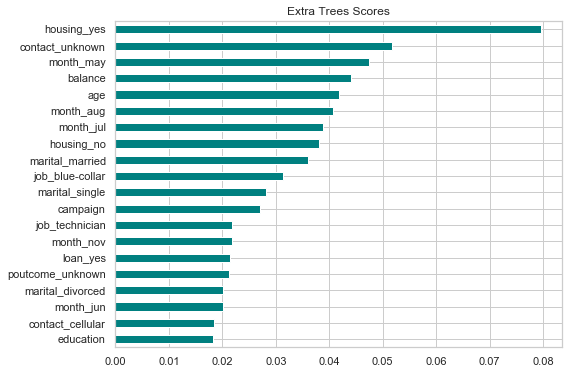

In [77]:
#Plotting scores
etc_series.sort_values(ascending=True).plot(kind='barh', color='teal', 
                                           figsize=(8,6), title='Extra Trees Scores')

**Random Forest Feature Importance**

In [78]:
#Creating object (default hyperparameters)

rfc=RandomForestClassifier()

#Fitting algorithm
rfc.fit(X=X_train, y=y_train)

#Adding scores to a series
rfc_series=pd.Series(rfc.feature_importances_, index=X_train.columns)

#Sorting
rfc_series=rfc_series.sort_values(ascending=False).head(20)

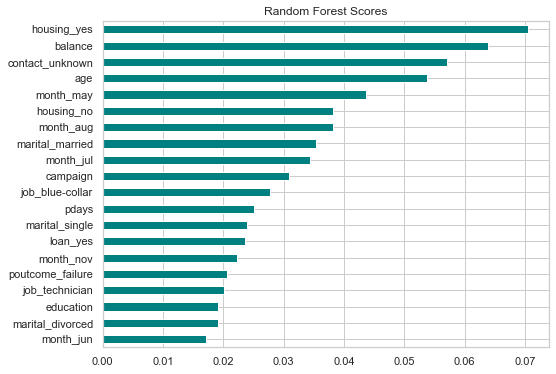

In [79]:
#Plotting scores
rfc_series.sort_values(ascending=True).plot(kind='barh', color='teal', 
                                           figsize=(8,6), title='Random Forest Scores')

**RFE**

In [80]:
#Creating object (with decision tree classifier algorithm on its 
#default hyperparameters)

rfe=RFE(estimator=DecisionTreeClassifier(), n_features_to_select=15)

#Fitting algorithm
rfe=rfe.fit(X=X_train, y=y_train)

#Collecting features
rfe_feat=X_train.columns[rfe.support_]

I decided to work with 15 features for now. The original dataset has 17 features so it doesn't seem reasonable to run a model with more features than the original dataset has. I am trying to prevent overfitting. Besides, all feature selection tecniques presented more or less the same features among the top 15 ones. If the models don't look nice at the end I may come back to add features if necessary.

In [81]:
# Creating X dataframes to evaluate the best set of features

#SelectKBest features
X_skb=X_train[skb_series.sort_values(ascending=False).head(15).index]

#Information Gain Features
X_ig=X_train[ig_series.sort_values(ascending=False).head(15).index]

#Extra Trees 
X_etc=X_train[etc_series.sort_values(ascending=False).head(15).index]

#Random Forest
X_rfc=X_train[rfc_series.sort_values(ascending=False).head(15).index]

#RFE
X_rfe=X_train[rfe_feat]

## Predictive Modeling

Defining function to run different algorithms in order to identify the set of features that performs best (best accuracy score). For now I'll run the models with their default hyperparemeters.

In [82]:
def classifiers(X, y, printMeans = True, scoring='accuracy'):
    
    # Setting seed and number of folds.
    
    folds = 5

    # List to save models.

    models = []

    # Lists to save results and the names of the algorithms.

    results = []
    names   = []

    # Dataframe to save means and standard deviations.

    means   = pd.DataFrame(columns = ['mean', 'std'])

    #Appending models to the models list. I'm running algorithms 
    #with their default hyperparemeters.

    models.append(('Logistic Regression', LogisticRegression()))
    models.append(('Naive Bayes', GaussianNB()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('SVM', SVC()))
    models.append(('AdaBoost', AdaBoostClassifier()))
    models.append(('Gradient Boosting', GradientBoostingClassifier()))
    models.append(('Random Forest', RandomForestClassifier()))

    # Evaluation

    for name, model in models:
        
        # Kfold object.

        fold = KFold(n_splits = folds)
        
        # Cross Validation.

        cv_results = cross_val_score(model, X, y, cv = fold, scoring = scoring)
        
        # Appending results to results list.

        results.append(cv_results)
        
        # Appending algorithm names to names list.

        names.append(name)

        # Saving means and standard deviations to means dataframe

        means = means.append (
            pd.DataFrame (
                data    = [[cv_results.mean(), cv_results.std()]], 
                columns = ['mean', 'std'], 
                index   = [name]
            )
        )

        # Printing results (default is 'True')
        
        if printMeans:
            msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
            print(msg)

    # Dataframe with results

    results = pd.DataFrame(np.transpose(results), columns = names)

    # Return dataframe
    return (results, means)

In [83]:
## Evaluating algorithms with features selected by SelectKBest

check_skb=classifiers(X=X_skb, y=y_train)

Logistic Regression: 0.833862 (0.017931)
Naive Bayes: 0.849371 (0.037173)
KNN: 0.687811 (0.244034)
CART: 0.829754 (0.010687)
SVM: 0.830638 (0.011773)
AdaBoost: 0.831615 (0.020996)
Gradient Boosting: 0.831707 (0.014496)
Random Forest: 0.832388 (0.016553)


In [84]:
## Evaluating algorithms with features selected by Information Gain

check_ig=classifiers(X=X_ig, y=y_train)

Logistic Regression: 0.786082 (0.039216)
Naive Bayes: 0.800801 (0.043336)
KNN: 0.778586 (0.024384)
CART: 0.794519 (0.015990)
SVM: 0.804354 (0.013562)
AdaBoost: 0.767792 (0.047835)
Gradient Boosting: 0.786874 (0.038722)
Random Forest: 0.823805 (0.015643)


In [85]:
## Evaluating algorithms with features selected by Extra Trees

check_etc=classifiers(X=X_etc, y=y_train)

Logistic Regression: 0.823382 (0.022813)
Naive Bayes: 0.839111 (0.027243)
KNN: 0.831522 (0.017078)
CART: 0.832260 (0.039729)
SVM: 0.831817 (0.023287)
AdaBoost: 0.823032 (0.025471)
Gradient Boosting: 0.835022 (0.016732)
Random Forest: 0.859022 (0.021923)


In [86]:
## Evaluating algorithms with features selected by Random Forest

check_rfc=classifiers(X=X_rfc, y=y_train)

Logistic Regression: 0.816088 (0.024826)
Naive Bayes: 0.833273 (0.034828)
KNN: 0.839498 (0.017766)
CART: 0.838762 (0.040373)
SVM: 0.849942 (0.013850)
AdaBoost: 0.823602 (0.020694)
Gradient Boosting: 0.830325 (0.017090)
Random Forest: 0.871805 (0.024395)


In [87]:
## Evaluating algorithms with features selected by RFE

check_rfe=classifiers(X=X_rfe, y=y_train)

Logistic Regression: 0.853294 (0.020655)
Naive Bayes: 0.853626 (0.031418)
KNN: 0.850918 (0.015721)
CART: 0.847916 (0.033836)
SVM: 0.858211 (0.020396)
AdaBoost: 0.847989 (0.019746)
Gradient Boosting: 0.855633 (0.015897)
Random Forest: 0.874071 (0.022115)


Features selected by RFE presented better accuracy scores. Scores are around the same for all algorithms, so I'll discard SVM because it is too computationally demanding.

In [88]:
# Preparing features 

#Test set
X_rfe_test=X_test[rfe_feat]

In [89]:
#Function to train and test

def do_train_test(algorithm):

    # Object with the selected model
    algo=algorithm
    
    #print chosen algorithm
    print('Algorithm:', algo)

    #Training and Testing
    model=algo.fit(X_rfe,y_train)

    #Train result
    model_train_result=model.score(X_rfe,y_train)

    print("Accuracy on training: %.3f%%" % (model_train_result * 100.0))

    #Test results
    model_pred=model.predict(X_rfe_test)

    model_test_result=accuracy_score(y_test,model_pred)

    print("Accuracy on test: %.3f%%" % (model_test_result * 100.0))

In [90]:
#Training and testing with selected algorithms

algo=[RandomForestClassifier(),GradientBoostingClassifier(), AdaBoostClassifier(),
      GaussianNB(), LogisticRegression()]

In [91]:
list(map(do_train_test, algo))

Algorithm: RandomForestClassifier()
Accuracy on training: 99.604%
Accuracy on test: 84.142%
Algorithm: GradientBoostingClassifier()
Accuracy on training: 88.083%
Accuracy on test: 85.768%
Algorithm: AdaBoostClassifier()
Accuracy on training: 87.527%
Accuracy on test: 85.525%
Algorithm: GaussianNB()
Accuracy on training: 85.280%
Accuracy on test: 83.700%
Algorithm: LogisticRegression()
Accuracy on training: 87.427%
Accuracy on test: 85.635%


[None, None, None, None, None]

I clearly have overfitting with Random Forest. Now I'll take a quick look at the metrics of the other algorithms

In [92]:
#Function to create classification report for selected algorithms

    
def classifiers_metrics(X_train, y_train, X_test, y_test):

    # List to save models.

    models = []

    # Lists to save the names of the algorithms.
    
    names   = []

    #Appending models to the models list. 
    
    models.append(('Gradient Boosting', GradientBoostingClassifier()))
    models.append(('AdaBoost', AdaBoostClassifier()))
    models.append(('Naive Bayes', GaussianNB()))
    models.append(('Logistic Regression', LogisticRegression()))


    # Evaluation

    for name, model in models:
        
        #Saving names to the list
        names.append(name)
        
        #Training and Testing
        pred = model.fit(X_train,y_train).predict(X_test)
        
        # Metrics report      
        print('Accuracy of', name, 'on test set: {:.3f}'.format(model.score(X_test,y_test)))
        print(classification_report(y_test, pred))  

In [93]:
classifiers_metrics(X_rfe, y_train, X_rfe_test, y_test)

Accuracy of Gradient Boosting on test set: 0.858
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      7985
           1       0.40      0.41      0.40      1058

    accuracy                           0.86      9043
   macro avg       0.66      0.67      0.66      9043
weighted avg       0.86      0.86      0.86      9043

Accuracy of AdaBoost on test set: 0.855
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      7985
           1       0.38      0.37      0.37      1058

    accuracy                           0.86      9043
   macro avg       0.65      0.64      0.65      9043
weighted avg       0.85      0.86      0.85      9043

Accuracy of Naive Bayes on test set: 0.837
              precision    recall  f1-score   support

           0       0.92      0.89      0.91      7985
           1       0.34      0.40      0.37      1058

    accuracy                           0.84      9

All agorithms present similar metrics, other than Naive Bayes. Gradient Boosting showed slightly better metrics. 

Text(0.5, 12.453125, 'Predicted label')

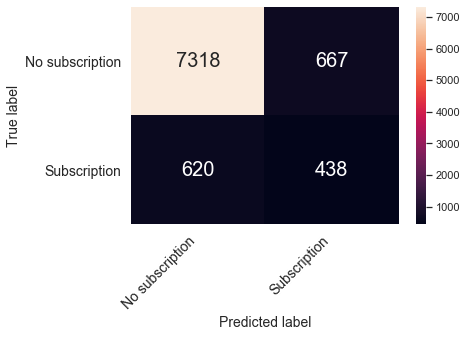

In [94]:
#Confusion_matrix of Gradient Boosting model

#Training gradient boosting
model=GradientBoostingClassifier()
model.fit(X_rfe,y_train)

y_pred= model.predict(X_rfe_test)
confusion_matrix = confusion_matrix(y_test, y_pred)

confusion_matrix_df = pd.DataFrame(confusion_matrix, ('No subscription', 'Subscription'), ('No subscription', 'Subscription'))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
plt.ylabel('True label', fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)

The models are not predicting the subscription class (1) well. There is a high amount of false negatives and false positives. First I'll try to rebalance the dataset to see if I get better results, than I'll try to tune the hyperparameters to see if I get better metrics.

In [95]:
#ROC AUC score

from sklearn.metrics import roc_auc_score

round(roc_auc_score(y_test,y_pred),2)

0.67